#### Description

Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Studying the Action vectors

#### Imports

In [1]:
import os
from six.moves import xrange 
import PIL.Image as Image
import random
import numpy as np
import cv2
import time
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage import io
from sklearn import metrics
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hcluster
from sklearn.metrics import silhouette_score

# Custom scripts
import lscript as lsp
import modelling as md

Using TensorFlow backend.


In [2]:
height=112 
width=112 
channel=3
crop_size=112
cluster_length=16
feature_size=8192

####  Loading model 

In [3]:
## Defining placeholders in tf for images and targets
x_image = tf.placeholder(tf.float32, [None, cluster_length,height,width,channel],name='x') 

model_keras = md.C3D_ucf101_training_model_tf(summary=False)
out=model_keras(x_image)

print('Miscellenious items finished..!!',flush=True)

/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_Tier_2/modelling.py:392: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), activation="relu", name="conv1", input_shape=(16, 112, ..., padding="same")`
  input_shape=input_shape))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_Tier_2/modelling.py:394: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid")`
  border_mode='valid', name='pool1'))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_Tier_2/modelling.py:397: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, (3, 3, 3), activation="relu", name="conv2", padding="same")`
  border_mode='same', name='conv2'))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_Tier_2/modelling.py:399: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D

Miscellenious items finished..!!


####  Feature extraction

In [4]:
## Getting 16 frames after unifrom sampling of video sample
def get_compress_frames_data(filename, num_frames_per_clip=16):
  ''' Given a directory containing extracted frames, return a video clip of
  (num_frames_per_clip) consecutive frames as a list of np arrays '''
  ret_arr = []
  for parent, dirnames, filenames in os.walk(filename):

    filenames = sorted(filenames)
    jump=math.floor((len(filenames)/num_frames_per_clip))
    loop=0
    for i in range(0,len(filenames),jump):
      if (loop>15):
        break
      if (filenames[i].endswith('.png')):
        image_name = str(filename) + '/' + str(filenames[i])
        img = Image.open(image_name)
        img_data = np.array(img)
        ret_arr.append(img_data)
        loop=loop+1
  ret_arr=np.array(ret_arr)
  #ret_arr=ret_arr/255
  return np.array(ret_arr)

In [5]:
## Feature extraction
def get_features_from_class(class_folder):
    feature_set_a=[]
    base_dir_a=class_folder
    sub_dir_a=os.listdir(base_dir_a)
    sub_dir_a=sorted(sub_dir_a)
    print(sub_dir_a)
    if '.DS_Store' in sub_dir_a:
        sub_dir_a.remove('.DS_Store')
    for sub_dir_a_ in sub_dir_a:
        vid_a=get_compress_frames_data(base_dir_a+sub_dir_a_)
        feature_set_a.append(extract_video_features(vid_a))
    return np.array(feature_set_a)

#### Load model and features

In [62]:
saved_path='/nobackup/leopauly/S2l/'
## Start the session with logging placement.
init_op = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
sess.run(init_op)

## Restore model weights from previously saved model
saver = tf.train.Saver()
#saver.restore(sess, os.path.join(saved_path,'activity_model.ckpt-67'))
print("Model restored from file: %s" % saved_path,flush=True)

Model restored from file: /nobackup/leopauly/S2l/


In [63]:
## Extraction of features 
def extract_video_features(vid):
    vid_=vid.reshape(-1,cluster_length,height,width,channel)
    f_v = sess.graph.get_tensor_by_name('flatten_1/Reshape:0') #('flatten_1/Reshape:0') #('pool4/MaxPool3D:0') #('dropout_1/cond/Merge:0') #('fc8/BiasAdd:0') 
    f_v_val=sess.run([f_v], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 })#f_v_val=sess.run([y_pred], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 })
    features=np.reshape(f_v_val,(-1))
    return features

In [64]:
feature_set_a=get_features_from_class('/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Push/')

['.DS_Store', 'push_demo_0deg', 'push_demo_180deg', 'push_demo_human', 'push_robo', 'push_robo_M2', 'push_robo_M3', 'push_robo_arbview1', 'push_robo_bg_fast', 'push_robo_change_pos', 'push_robo_changetarget', 'push_robo_comp0', 'push_robo_comp1', 'push_robo_comp2', 'push_robo_fast', 'push_robo_green', 'push_robo_obj2_new', 'push_robo_sideview']


In [65]:
feature_set_b=get_features_from_class('/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Reach/')

['.DS_Store', 'reach_demo_0deg', 'reach_demo_180deg', 'reach_demo_green', 'reach_human', 'reach_robo', 'reach_robo_M2', 'reach_robo_M3', 'reach_robo_arbview1', 'reach_robo_bg', 'reach_robo_change_pos', 'reach_robo_change_target', 'reach_robo_comp0', 'reach_robo_comp1', 'reach_robo_comp2', 'reach_robo_fast', 'reach_robo_obj2', 'reach_robo_sideview_new']


In [66]:
feature_set_c=get_features_from_class('/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Reach n Push/')

['.DS_Store', 'Multi_robo_M3', 'multi_demo_0deg', 'multi_demo_180deg', 'multi_robo', 'multi_robo_M2', 'multi_robo_arbview1', 'multi_robo_bg', 'multi_robo_change_pos', 'multi_robo_change_target', 'multi_robo_comp0', 'multi_robo_comp1', 'multi_robo_comp2', 'multi_robo_fast_new', 'multi_robo_human_new', 'multi_robo_obj', 'multi_robo_obj2', 'multi_robo_sideview']


#### Clustering 

In [67]:
points=np.concatenate((feature_set_a,feature_set_b,feature_set_c),axis=0)

In [68]:
## True labels
num_test_video_per_class=17
y_true_a=np.ones(num_test_video_per_class)*0
y_true_b=np.ones(num_test_video_per_class)*1
y_true_c=np.ones(num_test_video_per_class)*2
y_true=np.concatenate((y_true_a,y_true_b,y_true_c),axis=0)

print('\n')
print(y_true[0:17])
print(y_true[17:34])
print(y_true[34:51])



[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]


In [69]:
ari_score_list=[]
for n_clusters in range(1,52):
    
    kmeans = KMeans(n_clusters=n_clusters,random_state=1)
    y_km = kmeans.fit_predict(points)
    
    ari_score_list.append(round(metrics.adjusted_rand_score(y_true,y_km),2))

No: of clusters: 11 
 0.2


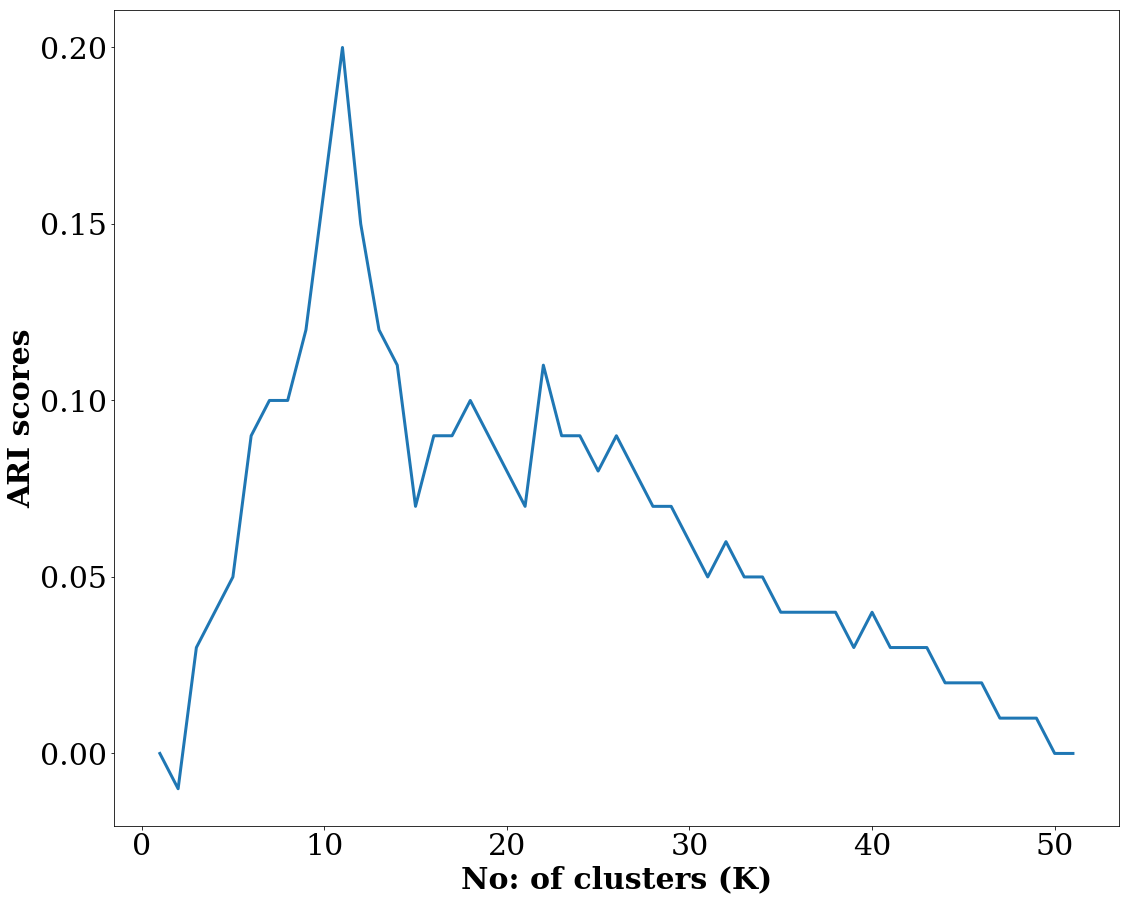

In [70]:
n_clusters=np.argmax(ari_score_list)+1
print('No: of clusters:',n_clusters,'\n',np.max(ari_score_list))

plt.rcParams.update({'font.size': 30})
plt.rcParams["font.family"] = "serif"
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams["figure.figsize"] = [18, 15]
plt.plot(range(1,52),ari_score_list,label='fc8',linewidth=3.0)#,marker='o')
plt.ylabel('ARI scores') 
plt.xlabel('No: of clusters (K)') 
#my_xticks = ['D-A','D-B','D-C','D-D','D-E']
#plt.xticks([0,1,2,3,4],my_xticks)
#plt.legend(loc='upper right',bbox_to_anchor=(1, 0.2))
plt.show()

In [15]:
plt.figure(figsize=(20, 10))
plt.plot(range(1,52),ari_score_list_rand,color='black',label='Baseline-R',linewidth=2.0)
plt.plot(range(1,52),ari_score_list_pool5,color='blue',label='pool5',linewidth=2.0)
plt.plot(range(1,52),ari_score_list_fc6,color='green',label='fc6',linewidth=2.0)
plt.plot(range(1,52),ari_score_list_fc7,color='brown',label='fc7',linewidth=2.0)
plt.plot(range(1,52),ari_score_list_fc8,color='pink',label='fc8',linewidth=2.0)
plt.legend(fontsize=25)
plt.savefig('ARIvsclusters.png')
plt.show()

NameError: name 'ari_score_list_rand' is not defined

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(range(1,52),ari_score_list_rand,color='black',label='Baseline-R',linewidth=2.0)
plt.legend(fontsize=25)
plt.savefig('ARIvsclusters_rand.png')
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(range(1,52),ari_score_list_pool5,color='blue',label='pool5',linewidth=2.0)
plt.legend(fontsize=25)
plt.savefig('ARIvsclusters_pool5.png')
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(range(1,52),ari_score_list_fc6,color='green',label='fc6',linewidth=2.0)
plt.legend(fontsize=25)
plt.savefig('ARIvsclusters_fc6.png')
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(range(1,52),ari_score_list_fc7,color='brown',label='fc7',linewidth=2.0)
plt.legend(fontsize=25)
plt.savefig('ARIvsclusters_fc7.png')
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(range(1,52),ari_score_list_fc8,color='red',label='fc8',linewidth=2.0)
plt.legend(fontsize=25)
plt.savefig('ARIvsclusters_fc8.png')
plt.show()

In [ ]:
## Predicting points
kmeans = KMeans(n_clusters=2,random_state=1)
y_km = kmeans.fit_predict(points)

print('\n')
print(y_km[0:17])
print(y_km[17:34])
print(y_km[34:51])

## True labels
num_test_video_per_class=17
y_true_a=np.ones(num_test_video_per_class)*0
y_true_b=np.ones(num_test_video_per_class)*1
y_true_c=np.ones(num_test_video_per_class)*2
y_true=np.concatenate((y_true_a,y_true_b,y_true_c),axis=0)

print('\n')
print(y_true[0:17])
print(y_true[17:34])
print(y_true[34:51])

## Reults
print('\n')
print('Adjusted random score:',round(metrics.adjusted_rand_score(y_true,y_km),2))
print('Adjusted mutual infromation score:',metrics.adjusted_mutual_info_score(y_true,y_km))
print('Homogeneity score:',metrics.homogeneity_score(y_true,y_km))
print('V measure score:',round(metrics.v_measure_score(y_true,y_km),2))